# **Técnicas Avanzadas de Aprendizaje**

## Actividad individual 2: "ACCIDENTES CEREBROVASCULARES"

Fabio Santamaría Iglesias

14/06/2021

# **Introducción: Dataset**

Este conjunto de datos se utiliza para predecir si es probable que un paciente sufra un accidente cerebrovascular en función de los parámetros de entrada como el sexo, la edad, diversas enfermedades y el tabaquismo. Cada fila de datos proporciona información relevante sobre el paciente.

Información de atributos:

* Id: identificador único. 
* Gender: "Masculino", "Femenino" u "Otro". 
* Age: edad del paciente. 
* Hypertension: 0 si el paciente no tiene hipertensión, 1 si el paciente tiene hipertensión.
* Heart_disease: 0 si el paciente no tiene ninguna enfermedad cardíaca, 1 si el paciente tiene una enfermedad cardíaca. 
* Ever_married: si ha estado alguna vez casado: "No" o "Yes". 
* Work_type: "Children/Cuidado de hijos", "Govt_job/Funcionario del Gobierno", "Never_worked/Nunca ha trabajado", "Private/trabajador por cuenta ajena" o "Self-employeed/Trabajador por cuenta propia". 
* Residence_type: "Rural" o "Urbano". 
* Avg_glucose_level: nivel medio de glucosa en sangre. 
* Bmi: índice de masa corporal (IMC). 
* Smoking_status: "Fue fumador", "Nunca ha fumado", "Fuma actualmente" o "Desconocido". 
* Stroke: 1 si el paciente tuvo un accidente cerebrovascular o 0 si no lo tuvo. 

Se importan las librerías básicas con las que trabajaremos:

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## **Lectura del dataset**

Subimos el archivo al entorno:

In [40]:
from google.colab import files

files.upload()

{}

Se lee el archivo y se pintan los primeros registros:

In [41]:
path = "/content/act1_healthcare-dataset-stroke-data.csv"
df_ini = pd.read_csv(path, sep=",")
print(df_ini.shape)
df_ini.head()

(5110, 12)


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


Se ve de qué tipo son nuestras variables:

In [42]:
df_ini.dtypes

id                     int64
gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

Como vemos, contamos con 5110 registros de 12 variables de diferente tipo. 

Analicemos el conjunto de datos buscando valores faltantes:



In [43]:
np.sum(df_ini.isnull())

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

Encontramos que en la variable *bmi* hay 201 datos nulos. Teniendo en cuenta que el conjunto total se compone 5110, decidimos eliminar estos registros:

In [44]:
df_ini.dropna(inplace = True)
df_ini.reset_index(inplace = True, drop = True)
print(df_ini.shape)

(4909, 12)


In [45]:
np.sum(df_ini.isnull())

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

Centrémonos en la variable que queremos predecir, *strokes*:

In [46]:
df_ini["stroke"].value_counts()

0    4700
1     209
Name: stroke, dtype: int64

Como es lógico, es una variable binaria, siendo 0 la clase mayoritaria y 1 la minoritaria. Si calculamos el porcentaje que representa cada clase del total,

In [47]:
df_ini["stroke"].value_counts()/len(df_ini)

0    0.957425
1    0.042575
Name: stroke, dtype: float64

nos damos cuenta de que la diferencia es notable, habiendo un 95,7% de casos negativos frente a un 4,3% de casos positivos. Estamos, por tanto, ante un conjunto de datos asimétrico (skewed dataset).

## **Preprocesado de datos:**

Para que nuestro algoritmo funcione correctamente, todas las variables deben ser numéricas. Usamos la función *LabelEncoder* para transformarlas y creamos un pequeño diccionario por si en el futuro procediese consultar los valores:

In [48]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

df = df_ini.copy(deep=True)

df["gender"]=le.fit_transform(df_ini.gender)
df["ever_married"]=le.fit_transform(df_ini.ever_married)
df["work_type"]=le.fit_transform(df_ini.work_type)
df["Residence_type"]=le.fit_transform(df_ini.Residence_type)
df["smoking_status"]=le.fit_transform(df_ini.smoking_status)

diccionario=pd.DataFrame({
    "original_gender": df_ini.gender,
    "codified_gender": df.gender,
    "original_ever_married": df_ini.ever_married,
    "codified_ever_married": df.ever_married,
    "original_work_type": df_ini.work_type,
    "codified_work_type": df.work_type,
    "original_Residence_type": df_ini.Residence_type,
    "codified_Residence_type": df.Residence_type,
    "original_smoking_status": df_ini.smoking_status,
    "codified_smoking_status": df.smoking_status,
})

diccionario.head()

,original_gender,codified_gender,original_ever_married,codified_ever_married,original_work_type,codified_work_type,original_Residence_type,codified_Residence_type,original_smoking_status,codified_smoking_status
0,Male,1,Yes,1,Private,2,Urban,1,formerly smoked,1
1,Male,1,Yes,1,Private,2,Rural,0,never smoked,2
2,Female,0,Yes,1,Private,2,Urban,1,smokes,3
3,Female,0,Yes,1,Self-employed,3,Rural,0,never smoked,2
4,Male,1,Yes,1,Private,2,Urban,1,formerly smoked,1


Así, a cada valor original le es asignado un número.

Dado que el algoritmo **knn** (*k-nearest neighbors*) se basa en calcular distancias entre los registros combinando las variables explicativas, y como deseamos tratar con igual relevancia a todas estas variables, necesitamos que estas tengan un orden de magnitud similar entre ellas. Para conseguir esto, usamos la función *StandardScaler* de *sklearn.preprocessing* para tipificarlas, es decir, que tengan media 0 y desviación típica 1. 

In [49]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled = scaler.fit(df.iloc[:,0:-1]).transform(df.iloc[:,0:-1])

In [50]:
dfs = pd.DataFrame(scaled, columns=df.columns[:-1])
dfs.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
0,-1.334653,1.198428,1.070138,-0.318067,4.381968,0.729484,-0.155697,0.985640,2.777698,0.981345,-0.351788
1,-0.283539,1.198428,1.646563,-0.318067,4.381968,0.729484,-0.155697,-1.014569,0.013842,0.459269,0.585232
2,1.101211,-0.833023,0.272012,-0.318067,-0.228208,0.729484,-0.155697,0.985640,1.484132,0.701207,1.522252
3,-1.686247,-0.833023,1.602222,3.143994,-0.228208,0.729484,0.759651,-1.014569,1.549193,-0.623083,0.585232
4,0.933870,1.198428,1.690903,-0.318067,-0.228208,0.729484,-0.155697,0.985640,1.821368,0.013595,-0.351788


In [51]:
dfs = pd.concat([dfs, df["stroke"]], axis=1)
dfs.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,-1.334653,1.198428,1.070138,-0.318067,4.381968,0.729484,-0.155697,0.985640,2.777698,0.981345,-0.351788,1
1,-0.283539,1.198428,1.646563,-0.318067,4.381968,0.729484,-0.155697,-1.014569,0.013842,0.459269,0.585232,1
2,1.101211,-0.833023,0.272012,-0.318067,-0.228208,0.729484,-0.155697,0.985640,1.484132,0.701207,1.522252,1
3,-1.686247,-0.833023,1.602222,3.143994,-0.228208,0.729484,0.759651,-1.014569,1.549193,-0.623083,0.585232,1
4,0.933870,1.198428,1.690903,-0.318067,-0.228208,0.729484,-0.155697,0.985640,1.821368,0.013595,-0.351788,1


Observamos que *age* está tipificada:

In [52]:
print (round(dfs["age"].mean(),2))
print (round(dfs["age"].std(),2))

0.0
1.0


Para asegurarnos de que nuestro algoritmo funciona correctamente, permutamos las observaciones con la finalidad de evitar patrones indeseados: 

In [53]:
dfs = dfs.sample(frac=1.0, random_state=42)

## **Selección del modelo KNN con Cross Validation**

Vamos a generar varios modelos con diferente número de vecinos. Esto nos permitirá seleccionar aquel con una mayor *accuracy*.

Hacemos un bucle sobre el número de vecinos, k. Como nuestro problema consiste en clasificar en dos clases, tratamos de evitar valores de k pares.

Creamos cada modelo con la función *KNeighborsClassifier* del paquete *sklearn*, cuyos parámetros fundamentales son los siguientes:

* n_neighbors: número de vecinos en los que queremos que se base nuestra predicción. Su valor puede ser cualquier número entero positivo. En nuestro caso, cambiaremos este valor para generar los diferentes modelos, ignorando los números pares para evitar el empate a la hora de decidir entre las dos clases.

* weights: con este parámetro indicamos cómo queremos que la distancia entre los vecinos influya en la predicción. Hay 3 posibles valores:

  - "uniform": todos los vecinos se consideran igualmente, independientemente de la distancia. Este el valor por defecto.

  - "distance": los vecinos cercanos tienen una influencia mayor que los lejanos.

  - "[callable]": podemos introducir cualquier función que deseemos.

 En nuestro caso, dejaremos el este parámetro es su valor por defecto, y por tanto cada vecino contará igual que el resto.

* metric: métrica usada para calcular las distancias, siendo 'minkowski' el valor por defecto. En nuestro caso, usaremos la métrica euclídea, indicando 'euclidean' en este parámetro.


Una vez tenemos el modelo, calculamos sus predicciones. Para esto usamos un generador de validación cruzado (cross-validated generator), implementado con la función *cross_val_predict*. Esta divide el conjunto de datos en *cv* partes. Cada parte constituye un subconjunto test, siendo el resto el subcojunto de entrenamiento. De esta forma se obtienen predicciones para todo el conjunto de datos. Con el parámetro *method = "predict"* indicamos que queremos que nos devuelva las predicciones. Con *n_jobs = -1* le decimos que ejecute la función en paralelo aprovechando todos los núcleos que tenga la máquina.

Además, calculamos también la *accuracy* de cada modelo usando, otra vez, validación cruzada. Esto se implementa con la función *cross_val_score* indicando en el parámetro *scoring* lo que queremos obtener. Como la validación cruzada es realizada sobre las cv partes en las que se divide el conjunto de datos, la función nos devuelve un array con cv elementos. Definimos la *accuracy* del modelo como la media de los valores contenidos en este array.

Finalmente, representamos cada valor *accuracy* con respecto al número de vecinos. Esto facilitará escoger el modelo adecuado para nuestro problema.




In [54]:
X = dfs.iloc[:,0:-1]
Y = dfs.iloc[:,-1]

In [55]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_predict, cross_val_score

preds_list = []
score_list = []
k_list = []

#Dado que nuestro problema consiste en clasificar en dos clases, ignoramos los k números pares
#1, 3, 5, ... 19
for k in list(range(1, 20, 2)):
  knn_model = KNeighborsClassifier(n_neighbors=k, weights="uniform", metric="euclidean")
  preds = cross_val_predict(knn_model, X, Y, cv=5, method="predict", n_jobs=-1)
  score = cross_val_score(knn_model, X, Y, cv=5, scoring="accuracy")
  k_list.append(k)
  preds_list.append(preds)
  score_list.append(score.mean())

#representamos 
df_scores = pd.DataFrame({"K":k_list, 
                   "score":score_list
                   })

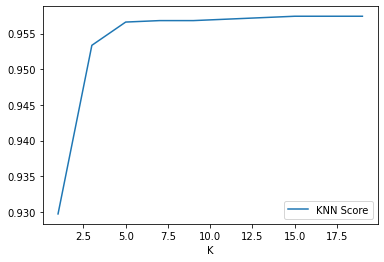

In [56]:
df_scores.set_index("K")["score"].plot(label="KNN Score")
plt.legend()
plt.show();

In [57]:
score_list

[0.9297215319170139,
 0.9533515615430449,
 0.9566104249581144,
 0.9568140909458946,
 0.9568142985564837,
 0.9570179645442636,
 0.9572216305320437,
 0.9574252965198238,
 0.9574252965198238,
 0.9574252965198238]

Vemos que la tendencia es monótona creciente con respecto al aumento del número de vecinos, k. Más especificamente, la *accuracy* va aumentando entre los valores pequeños y a partir del valor k = 3 la función comienza a disminuir su pendiente hasta convertirse en prácticamente constante a partir del valor 5. Dependiendo del valor del número de vecinos podemos caer en los siguientes problemas:

* underfitting: cuando k es muy grande, podemos acabar clasificando todo el conjunto en una sola clase. Además, computacionalmente sería muy costoso, ya que tendríamos que calcular el valor de nuestra predicción teniendo en cuenta un número muy grande de vecinos. 

  Podemos observar este efecto en *score_list*. A partir del elemento correspondiente con **k = 15** y en adelante la accuracy se vuelve exactamente igual al porcentaje de datos de clase 0 que hay en nuestro conjuto de datos. Por tanto, estos modelos están prediciendo siempre negativos.

* overfitting: ocurre con k muy pequeño, **k < 5**. En este caso, las delimitaciones entre las clases serán complejas y nuestro modelo predecirá muy bien sobre el conjunto de entrenamiento pero muy mal sobre el conjunto test. 

En nuestro caso, es fácil ver cuándo entramos en *overfitting*, ya que la accuracy comienza a bajar. Por lo tanto, nos guiaremos por los valores de k pequeños. Así, **escogemos el modelo que tiene 5 vecinos** como el ideal para resolver esta tarea. 

Si nos fijamos en el valor de la *accuracy* para 5 vecinos, observamos que está en 95,6%. Este valor puede parecer alto, pero no tiene por qué serlo ya que nuestro modelo es asimétrico. Recordemos que el 95,7% de los valores respuesta son 0 mientras que solo el 4.3% son 1.

Como vemos, la "accuracy" no es la mejor métrica a la hora de tratar con un problema de clasificación, aunque sí nos sirve como referencia para seleccionar el valor de K. Existen otras como la curva ROC (acrónimo de Receiver Operating Characteristic) o la matriz de confusión que nos dan más información sobre la capacidad explicativa de nuestro modelo.

## **Entrenamiento y Evaluación del modelo**

Creamos nuestro modelo de 5 vecinos y elaboramos las predicciones con la función *cross_val_predict*. A través del argumento *method* indicamos qué queremos que nos devuelva la función. El valor "predic_proba" calcula las probabilidades para cada clase, que usaremos más adelante. Con "predict" nos devuelve si, de acuerdo al modelo, el valor predicho es un positivo o un negativo.

In [58]:
knn_model = KNeighborsClassifier(n_neighbors=5, weights="uniform", metric="euclidean")
probs = cross_val_predict(knn_model, X, Y, cv=5, method="predict_proba", n_jobs=3)
preds = cross_val_predict(knn_model, X, Y, cv=5, method="predict", n_jobs=3)

Una vez tenemos nuestro modelo, evaluamos su capacidad explicativa con diferentes métricas. Para ello, se define:

* $$ recall =  \frac{TP}{TP+FN}$$ 


* $$ Precision =  \frac{TP}{TP+FP}$$ 


* $$ F1 =  \frac{precision*recall}{precision+recall}$$ 

Donde:

* *TP*: Son los positivos verdaderos, es decir, aquellos donde nuestro clasificador acierta en clasificar un dato como positivo. 

* *FP*: Son los falsos positivos. En este caso, una predicción es positiva cuando su resultado real es negativo.

* *FN*: o falsos negativos, donde una predicción es negativa cuando su resultado real es positivo.

* Por completitud, se definen también los *TN*: predicciones negativas que son realmente negativas.

De esta forma, a partir de predicciones de nuestro modelo y los valores reales, obtenemos las siguientes métricas:


### **Matriz de confusión:**

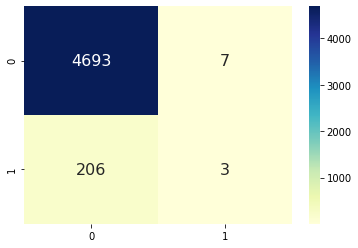

In [59]:
import seaborn as sn
df_cm = pd.DataFrame(confusion_matrix(Y, preds))
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt="d", cmap="YlGnBu")

Se obtienen 4693 verdaderos negativos (TN), 7 falsos positivos (FP), 206 falsos positivos (FN) y 3 verdaderos positivos (TP). Como vemos, nuestro modelo clasifica muy mal los positivos, pese a que el valor de *accuracy* era de 95,6%. Como ya comentamos, esto es debido a la asimetría de nuestro conjunto de datos, con un 95,7% de valores negativos y un 4,3% de valores positivos. Nuestro modelo está sesgado a clasificar un resultado como negativo y, por tanto, en la inmensa mayoría de casos acierta.

### **recall, precision y f1-score:**

Un informe más completo se puede obtener con la función *classification_report*:

In [60]:
from sklearn.metrics import classification_report
print(f"Informe de Clasificación:\n"
      f"{classification_report(Y, preds)}")

Informe de Clasificación:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      4700
           1       0.30      0.01      0.03       209

    accuracy                           0.96      4909
   macro avg       0.63      0.51      0.50      4909
weighted avg       0.93      0.96      0.94      4909



Desglosado por clase observamos que la precisión y el recall son muy buenos para la clase 0. Sin embargo, para los positivos, tenemos valores muy pobres, sobre todo el recall. Como ya vimos, la métrica F1 (*f1-score*) combina ambos indicadores, siendo 0.98 un valor muy bueno para la clase de negativos y 0.03 muy malo para la de positivos. Se concluye que, como ya intuíamos en la matriz de confusión, nuestro modelo está sesgado y tiende a clasificar los resultados como negativos.

Nuestro modelo considera 5 vecinos. Por tanto, **para una predicción existen 6 posibles resultados: 0, 0.2, 0.4, 0.6, 0.8 y 1**. Según estos valores, el modelo decide si clasificar la predicción en la clase 0 o en la clase 1. Por defecto, nuestro modelo está interpretando que si el resultado está por encima de 0.5 el resultado debe pertener a la clase 1, y si está por debajo, a la clase 0. 

El sesgo observado puede ser regulado variando este límite a partir del cual el modelo clasifica una predicción como positiva o negativa. Bajar este límite supone incrementar el recall a costa de la precision para la clase de positivos. Es decir, podremos obtener más verdaderos positivos, aunque esto signifique un mayor número de falsos positivos.

La función *precision_recall_curve* nos permite ver qué valores de *recall* y *precision* obtendríamos para cada uno de estos mencionados límites de discriminación:





In [61]:
from sklearn.metrics import precision_recall_curve
precision, recall, limite = precision_recall_curve(Y,probs[:,1])

In [62]:
precision

array([0.04257486, 0.09939394, 0.14383562, 0.3       , 1.        ])

In [63]:
recall

array([1.        , 0.3923445 , 0.10047847, 0.01435407, 0.        ])

In [64]:
limite

array([0. , 0.2, 0.4, 0.6])

Como vemos, solo tenemos 4 posibles límites. Esto se debe a que en ningún caso existen suficientes vecinos con valor 1 para obtener las probabilidades 0.8 y 1.

Con estos 4 límites se obtienen 4 valores no triviales para la precision y el recall (el quinto valor, 1 y 0 respectivamente, implica tener un modelo que considera todo como la clase 1, y por tanto no es un valor útil salvo para pintar la gráfica que sigue a continuación). Podemos graficar estos valores para verlos mejor:

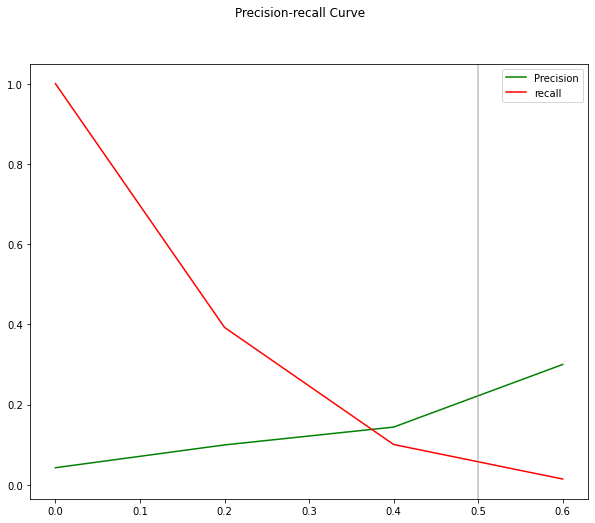

In [65]:
plt.figure(figsize=(10, 8))
plt.plot(limite, precision[:-1], c="green", label="Precision")
plt.plot(limite, recall[:-1], c="red", label="recall")
plt.axvline(0.5, alpha=0.5, c="gray")
plt.suptitle("Precision-recall Curve")
plt.legend()
plt.show()

La gráfica confirma lo que veníamos explicando, conforme bajamos el límite el recall aumenta y la precision disminuye. Se obtienen, por tanto, un mayor número de positivos, tanto verdaderos como falsos.

Al crear nuestro modelo obtuvimos las predicciones y las probabilidades de que la respuesta sea positiva o negativa. Combinemos esta información en un dataframe: 



In [66]:
df_dict = {"prob_class0": probs[:,0],
           "prob_class1": probs[:,1],
           "preds":preds}

df_probs = pd.DataFrame(df_dict)
df_probs.head()

,prob_class0,prob_class1,preds
0,0.8,0.2,0
1,1.0,0.0,0
2,1.0,0.0,0
3,1.0,0.0,0
4,1.0,0.0,0


Tengamos en cuenta ahora los diferentes límites de discriminación a partir de los cuales podría clasificar nuestro algoritmo:

In [67]:
df_probs["preds_20"] = 0
df_probs["preds_40"] = 0
df_probs["preds_60"] = 0

df_probs.loc[df_probs["prob_class1"]>=0.2, "preds_20"] = 1
df_probs.loc[df_probs["prob_class1"]>=0.4, "preds_40"] = 1
df_probs.loc[df_probs["prob_class1"]>=0.6, "preds_60"] = 1

df_probs.head()

,prob_class0,prob_class1,preds,preds_20,preds_40,preds_60
0,0.8,0.2,0,1,0,0
1,1.0,0.0,0,0,0,0
2,1.0,0.0,0,0,0,0
3,1.0,0.0,0,0,0,0
4,1.0,0.0,0,0,0,0


Podemos volver a usar las métricas vistas anteriormente sobre estos nuevos límites:

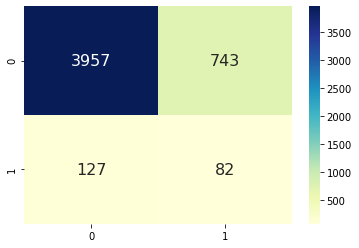

In [68]:
import seaborn as sn
df_cm = pd.DataFrame(confusion_matrix(Y, df_probs["preds_20"].values))
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt="d", cmap="YlGnBu")

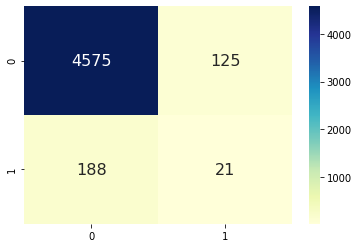

In [69]:
import seaborn as sn
df_cm = pd.DataFrame(confusion_matrix(Y, df_probs["preds_40"].values))
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt="d", cmap="YlGnBu")

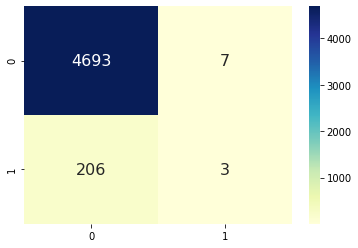

In [70]:
import seaborn as sn
df_cm = pd.DataFrame(confusion_matrix(Y, df_probs["preds_60"].values))
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt="d", cmap="YlGnBu")

Los resultados confirman lo que venimos explicando. Para el límite bajo de 0.2, con un alto recall y baja precision, tenemos muchos positivos, tanto falsos como verdaderos. Conforme vamos aumentando el límite el número de positivos va bajando.

### **Curva ROC y valor AUC:**

La curva ROC (Receiver Operating Characteristic) es una gráfica que ilustra la habilidad de un clasificador binario cuando variamos su límite de discriminación. La curva se pinta sobre un plano donde el eje *y* es el recall, también llamado sensitividad o TPR (*True positive rate*), y x es igual a 1 - especificidad, conocido también como FPR (*False Positive Rate*). Este último se define como:

${\displaystyle \mathrm {FPR} = \frac {\mathrm {FP} }{\mathrm {FP} +\mathrm {TN} }}$

De esta forma, una recta de pendiente 1 equivaldría a clasificar nuestras predicciones al azar, usando en nuestro caso una probibilidad del 95,7% para predecir un negativo y de un 4.3% para un positivo. Nuestra predicción no se basaría en ninguna variable explicativa. Por otro lado, si nuestro modelo es capaz de predecir en cierta medida, observaremos cómo la curva estará siempre por encima de esta línea de pendiente 1. Es decir, será mejor que usar el azar. Si por el contrario, nuestro modelo predijese peor que el azar, bastaría con invertir nuestro criterio de clasificación de clases. Por lo tanto, cualquier desviación de esta línea recta es considerado como algo positivo de cara a la utilidad del modelo. Cuanto más exagerada sea la diferencia entre la curva y la línea recta mejor será el modelo.

Con la función *roc_curve*, a partir de los valores reales de las probabilidades predichas por nuestro modelo, obtenemos tanto los valores FPR como los TPR para cada uno de nuestros límites de discriminación. Con estos valores construimos la curva *roc*.

Para poder comparar, se define el *auc* (Area under the curve) como el área bajo la curva ROC. En nuestro caso, realizamos el cálculo con la función *auc*.  



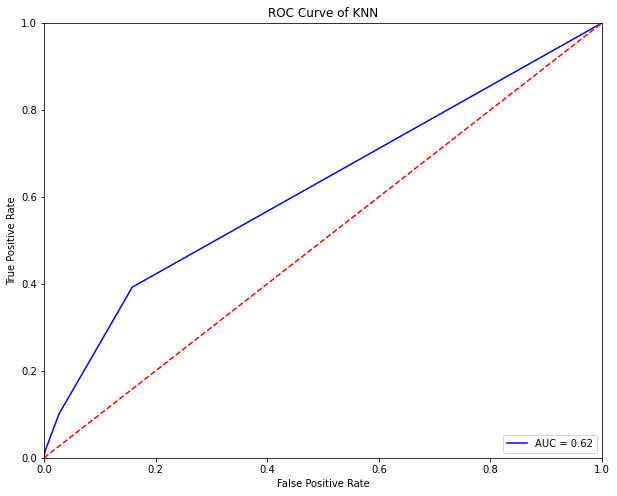

In [71]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

fpr, tpr, threshold = roc_curve(Y, probs[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 8))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of KNN')
plt.show()

Como vemos, nuestro modelo es mejor que usar predicciones al azar. El valor *AUC* es de 0.62, el cual comparamos con la siguiente escala estándar:

[0.5]: Es como lanzar una moneda.

[0.5, 0.6): Test malo.

[0.6, 0.75): Test regular.

[0.75, 0.9): Test bueno.

[0.9, 0.97): Test muy bueno.

[0.97, 1): Test excelente.

Observamos que nuestro modelo está entre malo y regular. Esto es consistente con los resultados anteriores, los cuales recopilaremos en el apartado final de conclusiones.

## **Conclusiones**:

Resumamos lo que hemos obtenido:

* Accuracy: se observó que a partir de 5 vecinos este valor se estanca entre el 95,5% y el 96%. Aunque parezca un resultado bueno, hay que tener en cuenta que nuestra variable respuesta tiene una cantidad muy diferente de negativos y positivos. En concreto, vimos que tenemos un 95,7% de valores con 0 y un 4.3% de valores con 1. Esta no es una buena métrica para evaluar la capacidad predictiva. Solo la usamos para elegir un modelo que no presentase ni *underfitting (k >= 15)* ni *overfitting (k < 5)*.

* Matriz de confusión: se vio que el modelo clasifica muy mal los positivos, siendo la mayoría falsos negativos (206 falsos negativos frente a 3 verdaderos positivos). Además, se obtuvo un número mayor de falsos positivos (7) que de verdaderos positivos. Concluimos que nuestro modelo tiende a predecir negativos.

* recall, precision y f1-score: calculamos un recall muy bajo de 0.01 y una precision baja de 0.30, dando como resultado un f1-score de 0.03 para la clase 1. Estos resultados concuerdan con lo observado en la matriz de confusión. Tal y como indica la precision, la mayoría de predicciones positivas son falsos positivos. Por su lado, un recall tan bajo nos dice que la inmensa mayoría de positivos reales son clasificados como falsos negativos.

  Remarcamos que nuestro modelo usa un límite de discriminación de 0.5 a la hora de clasificar. Graficamos el recall y la precision para los posibles valores de este límite. Consecuentemente obtuvimos que bajar el valor de discriminación aumenta el recall y disminuye la precision. También vimos las diferentes matrices de confusión para cada uno de estos umbrales.

* Curva ROC y AUC: Por último, dibujamos la curva ROC y calculamos su AUC obteniendo un valor de 0.62. Dentro del estándar, este resultado se corresponde con un modelo con una capacidad predictiva entre mala y regular.

Como conclusion final, resaltamos que si se quiere ser precavido y detectar la mayor cantidad de posibles accidentes cerebrovasculares es necesario usar un umbral de discriminación bajo, por ejemplo 0.2. Esto hará aumentar el recall a costa de disminuir la precision. Es decir, detectaremos más verdaderos positivos a expensas de tener un mayor número de falsos positivos.